In [1]:
import numpy as np
from ARMA import ARMA
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC, OneClassSVM
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load
from tqdm import tqdm
import os

In [2]:
case = 'chb01'
sset = 'Test'
fe = 'AR'
modelroot = './models' + '/' + case + '/' + fe


root = './data' + '/' + sset + '/' + case
cclass_a = 'Interictal'
cclass_b = 'Preictal'

interictal_dir = './data' + '/' + sset + '/' + case + '/' + cclass_a
preictal_dir = './data' + '/' + sset + '/' + case + '/' + cclass_b
interictal_files = os.listdir(interictal_dir)
preictal_files = os.listdir(preictal_dir)

In [3]:
interictal_data = []
for i, _ in enumerate(tqdm(interictal_files)):
    # interictal
    filepath = root + '/' + cclass_a + '/' + interictal_files[i]
    data = np.load(filepath)
    interictal_data.append(data)
del data, filepath

100%|██████████| 12/12 [00:01<00:00,  6.00it/s]


In [4]:
preictal_data = []
for i, _ in enumerate(tqdm(preictal_files)):
    # preictal
    filepath = root + '/' + cclass_b + '/' + preictal_files[i]
    data = np.load(filepath)
    preictal_data.append(data)
del data, filepath

100%|██████████| 3/3 [00:00<00:00, 10.65it/s]


In [5]:
interictal_input = np.hstack(interictal_data)
preictal_input = np.hstack(preictal_data)
print('Interictal:', interictal_input.shape, 'Preictal:', preictal_input.shape)
X = np.hstack((interictal_input, preictal_input))
print('All:', X.shape)

Interictal: (23, 2764812) Preictal: (23, 691203)
All: (23, 3456015)


### Online Prediction: Linear SVM

In [6]:
# online prediction parameters
sig = X                  # Feed input signal
fs = 256                 # sampling frequency (Hz)
N = 512                  # fs = N*fp (N must be a natural number)
fp = fs/N                # prediction frequency
n_i = 2                  # AR model order
t_s = 1/fs               # Input signal time period
n_c = X.shape[0]       # Number of EEG electrodes (channels)
m = 30                   # MA parameter

modelname = 'chb01_AR_SVM_Linear'
modelpath = modelroot + '/' + modelname + '.joblib'
model = load(modelpath) # load model

print(f'Model: {modelname}')
print(f'Input length: {sig.shape[1]}')
print(f'Input channels: {n_c}')
print(f'Model: AR({n_i})')
print(f'MA lookback: {m}')
print(f'Window size: {N}')
print(f'Sampling frequency: {fs} Hz')
print(f'Prediction frequency: {fp} Hz')

Model: chb01_AR_SVM_Linear
Input length: 3456015
Input channels: 23
Model: AR(2)
MA lookback: 30
Window size: 512
Sampling frequency: 256 Hz
Prediction frequency: 0.5 Hz


In [7]:
# online prediction
fp = fs/N                                                # Prediction frequency
t_s = 1/fs                                               # Input signal time period

a_k_list = []                                              # Sequential buffer for  MA samples
a_h_k_list = []                                            # Sequential buffer for AR signal samples
k_list = []                                                # Sequential buffer for time index in prediction point _k
preds = []

n_c = sig.shape[0]                                         # Number of input channels
n = sig.shape[1]                                           # Total number of input samples
a = 1.8 * np.random.randn(n_c, n_i)                   # Initialise AR coefficients
c = m * np.ones(m)                               # Initialise MA coefficients
c = c / c.sum()

Ik = N                                                # Window width
for _k in tqdm(range(Ik + n_i, n), desc='Classifying... '): # Sliding window
    if (_k % N == 0):                                 # Decimation policy: _k occurs once every N samples
        w_start = _k - Ik - n_i + 1                   # Starting index of sliding window (end index is maintained by _k)
        a_h = np.zeros((n_c, n_i))                    # AR parameter estimates from samples in window
        for _i in range(n_c):                              # Iterate channels
            x_t = sig[_i, w_start:_k]                      # Multi-channel window over input signal
            N_w = len(x_t)
            ymat = np.zeros((N_w - n_i, n_i))
            yb = np.zeros((N_w - n_i, n_i))
            for _c in range(n_i, 0, -1):              # Past dependency of AR up to model order
                ymat[ : , n_i - _c] = x_t[n_i - _c : -_c]
            yb = x_t[n_i:]
            a_h[_i] = np.linalg.pinv(ymat) @ yb            # Least squares solution to optimal parameters via Moore-Penrose Pseudo Inverse
        a_k = np.zeros((n_c, n_i))
        a_h_k_idx = len(a_h_k_list) - 1                    # Index to most recent block of AR parameters of shape: (n_c, n_i)
        for _j in range(m):                           # MA smoothing of AR parameters going back m units of time, in timescale k
            if len(a_h_k_list) > m:                   # Only begin smoothing once unit of time elapsed is greater than m
                a_k = c[_j] * a_h_k_list[a_h_k_idx - _j]
        a_k = np.mean(a_k, axis=0)                         # Mean over channels
        
        # classify a_k (feature)
        p = model.predict(a_k.reshape(1, -1))
        preds.append(p)        
        
        k_list.append(_k)
        a_h_k_list.append(a_h)
        a_k_list.append(a_k)
k = np.array(k_list)
a_h_k = np.array(a_h_k_list)
a_k = np.array(a_k_list)

Classifying... : 100%|██████████| 3455501/3455501 [00:32<00:00, 105076.32it/s]


In [8]:
prediction_sig = np.hstack(preds)
print(prediction_sig.shape)

t = np.arange(0, X.shape[1]) / fs
X_mean = np.mean(X, axis=0)
print(X_mean.shape)

t_preictal = np.rint(np.max(np.arange(0, interictal_input.shape[1]) / fs / 3600))
print('Preictal start time:', t_preictal)

k = np.hstack(k_list)
pt = np.arange(0, k.shape[0]) / (fs/N) / 3600

ar_mean = np.mean(a_h_k, axis=1)
print(ar_mean.shape)

(6749,)
(3456015,)
Preictal start time: 3.0
(6749, 2)


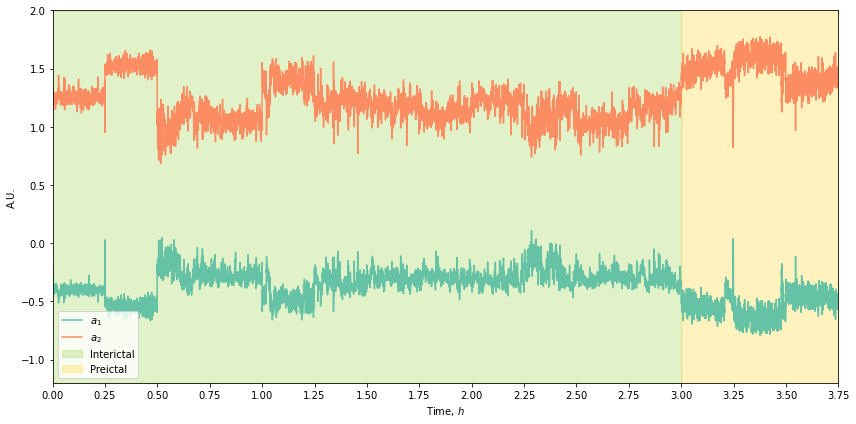

In [9]:
# AR coefficient response
sns.set_palette(sns.color_palette('Set2'))
plt.figure(figsize=(12,6))
sns.lineplot(x=pt, y=ar_mean[:,0], label='$a_1$')
ax = sns.lineplot(x=pt, y=ar_mean[:,1], label='$a_2$')
ax.fill_between(pt, 0, 1, where=pt < t_preictal, color='#9cd34a', alpha=0.3, transform=ax.get_xaxis_transform(), label='Interictal')
ax.fill_between(pt, 0, 1, where=pt > t_preictal, color='#ffd429', alpha=0.3, transform=ax.get_xaxis_transform(), label='Preictal')

plt.xticks(np.arange(0,3.76,0.25))
plt.xlim([0,3.75])
plt.ylim([-1.2,2])
plt.xlabel('Time, $h$')
plt.ylabel('A.U.')
plt.legend(loc=3)
plt.tight_layout()
plt.savefig('./figures/chb01_AR_RT.pdf')
plt.show()

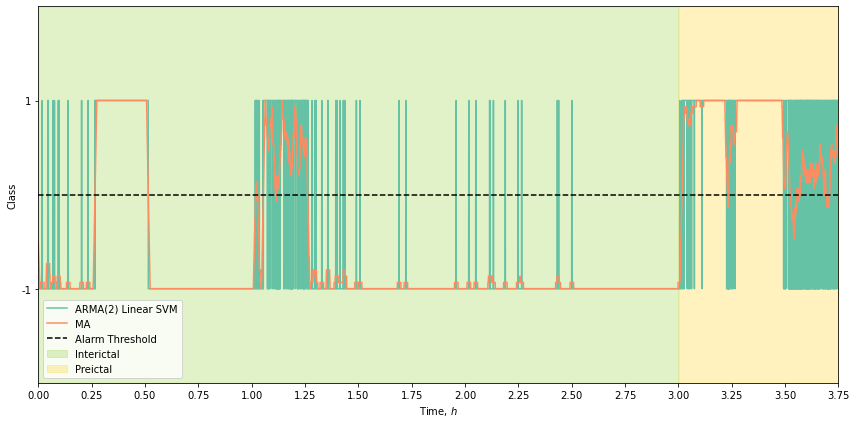

In [10]:
# online predictor response
sns.set_palette(sns.color_palette('Set2'))
plt.figure(figsize=(12,6))
m = 30
ma_predict_sig = np.convolve(prediction_sig, np.ones(m)/m, mode='same')
ax = sns.lineplot(x=pt, y=prediction_sig, label='ARMA(2) Linear SVM')
sns.lineplot(x=pt, y=ma_predict_sig, label='MA')
ax.axhline(y=0, ls='--', color='k', label='Alarm Threshold')
ax.fill_between(pt, 0, 1, where=pt < t_preictal, color='#9cd34a', alpha=0.3, transform=ax.get_xaxis_transform(), label='Interictal')
ax.fill_between(pt, 0, 1, where=pt > t_preictal, color='#ffd429', alpha=0.3, transform=ax.get_xaxis_transform(), label='Preictal')

plt.xticks(np.arange(0,3.76,0.25))
tickpos = [-1,1] # show only classes: -1 and 1
plt.yticks(tickpos,tickpos)

plt.xlim([0,3.75])
plt.ylim([-2,2])
plt.xlabel('Time, $h$')
plt.ylabel('Class')
plt.legend(loc=3)
plt.tight_layout()
plt.savefig('./figures/chb01_AR_SVM_Linear.pdf')
plt.show()

### Online Prediction: RBF SVM

In [11]:
# online prediction parameters
sig = X                  # Feed input signal
fs = 256                 # sampling frequency (Hz)
N = 512                  # fs = N*fp (N must be a natural number)
fp = fs/N                # prediction frequency
n_i = 2                  # AR model order
t_s = 1/fs               # Input signal time period
n_c = X.shape[0]       # Number of EEG electrodes (channels)
m = 30                   # MA parameter

modelname = 'chb01_AR_SVM_RBF'
modelpath = modelroot + '/' + modelname + '.joblib'
model = load(modelpath) # load model

print(f'Model: {modelname}')
print(f'Input length: {sig.shape[1]}')
print(f'Input channels: {n_c}')
print(f'Model: AR({n_i})')
print(f'MA lookback: {m}')
print(f'Window size: {N}')
print(f'Sampling frequency: {fs} Hz')
print(f'Prediction frequency: {fp} Hz')

Model: chb01_AR_SVM_RBF
Input length: 3456015
Input channels: 23
Model: AR(2)
MA lookback: 30
Window size: 512
Sampling frequency: 256 Hz
Prediction frequency: 0.5 Hz


In [12]:
# online prediction
fp = fs/N                                                # Prediction frequency
t_s = 1/fs                                               # Input signal time period

a_k_list = []                                              # Sequential buffer for  MA samples
a_h_k_list = []                                            # Sequential buffer for AR signal samples
k_list = []                                                # Sequential buffer for time index in prediction point _k
preds = []

n_c = sig.shape[0]                                         # Number of input channels
n = sig.shape[1]                                           # Total number of input samples
a = 1.8 * np.random.randn(n_c, n_i)                   # Initialise AR coefficients
c = m * np.ones(m)                               # Initialise MA coefficients
c = c / c.sum()

Ik = N                                                # Window width
for _k in tqdm(range(Ik + n_i, n), desc='Classifying... '): # Sliding window
    if (_k % N == 0):                                 # Decimation policy: _k occurs once every N samples
        w_start = _k - Ik - n_i + 1                   # Starting index of sliding window (end index is maintained by _k)
        a_h = np.zeros((n_c, n_i))                    # AR parameter estimates from samples in window
        for _i in range(n_c):                              # Iterate channels
            x_t = sig[_i, w_start:_k]                      # Multi-channel window over input signal
            N_w = len(x_t)
            ymat = np.zeros((N_w - n_i, n_i))
            yb = np.zeros((N_w - n_i, n_i))
            for _c in range(n_i, 0, -1):              # Past dependency of AR up to model order
                ymat[ : , n_i - _c] = x_t[n_i - _c : -_c]
            yb = x_t[n_i:]
            a_h[_i] = np.linalg.pinv(ymat) @ yb            # Least squares solution to optimal parameters via Moore-Penrose Pseudo Inverse
        a_k = np.zeros((n_c, n_i))
        a_h_k_idx = len(a_h_k_list) - 1                    # Index to most recent block of AR parameters of shape: (n_c, n_i)
        for _j in range(m):                           # MA smoothing of AR parameters going back m units of time, in timescale k
            if len(a_h_k_list) > m:                   # Only begin smoothing once unit of time elapsed is greater than m
                a_k = c[_j] * a_h_k_list[a_h_k_idx - _j]
        a_k = np.mean(a_k, axis=0)                         # Mean over channels
        
        # classify a_k (feature)
        p = model.predict(a_k.reshape(1, -1))
        preds.append(p)        
        
        k_list.append(_k)
        a_h_k_list.append(a_h)
        a_k_list.append(a_k)
k = np.array(k_list)
a_h_k = np.array(a_h_k_list)
a_k = np.array(a_k_list)

Classifying... : 100%|██████████| 3455501/3455501 [00:33<00:00, 103479.64it/s]


In [13]:
prediction_sig = np.hstack(preds) # online prediction sig
t = np.arange(0, X.shape[1]) / fs # times for input sig
X_mean = np.mean(X, axis=0) # input sig, mean over channels
t_preictal = np.rint(np.max(np.arange(0, interictal_input.shape[1]) / fs / 3600))
print('Preictal start time:', t_preictal)
k = np.hstack(k_list)
pt = np.arange(0, k.shape[0]) / (fs/N) / 3600
ar_mean = np.mean(a_h_k, axis=1)

Preictal start time: 3.0


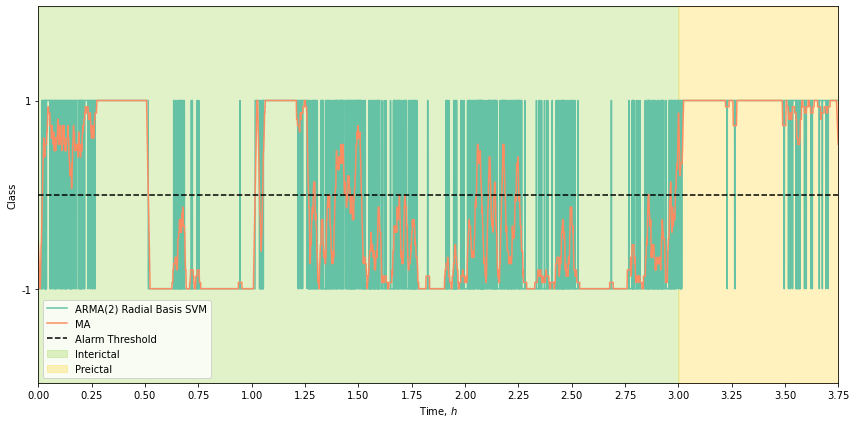

In [14]:
# online predictor response
plt.figure(figsize=(12,6))
sns.set_palette(sns.color_palette('Set2'))

m = 30
ma_predict_sig = np.convolve(prediction_sig, np.ones(m)/m, mode='same')
ax = sns.lineplot(x=pt, y=prediction_sig, label='ARMA(2) Radial Basis SVM')
sns.lineplot(x=pt, y=ma_predict_sig, label='MA')
ax.axhline(y=0, ls='--', color='k', label='Alarm Threshold')
ax.fill_between(pt, 0, 1, where=pt < t_preictal, color='#9cd34a', alpha=0.3, transform=ax.get_xaxis_transform(), label='Interictal')
ax.fill_between(pt, 0, 1, where=pt > t_preictal, color='#ffd429', alpha=0.3, transform=ax.get_xaxis_transform(), label='Preictal')

plt.xticks(np.arange(0,3.76,0.25))
tickpos = [-1,1] # show only classes: -1 and 1
plt.yticks(tickpos,tickpos)

plt.xlim([0,3.75])
plt.ylim([-2,2])
plt.xlabel('Time, $h$')
plt.ylabel('Class')
plt.legend(loc=3)
plt.tight_layout()
plt.savefig(f'./figures/chb01_AR_SVM_RBF_RT.pdf')
plt.show()

### Online Prediction: Logistic Regression

In [15]:
# online prediction parameters
sig = X                  # Feed input signal
fs = 256                 # sampling frequency (Hz)
N = 512                  # fs = N*fp (N must be a natural number)
fp = fs/N                # prediction frequency
n_i = 2                  # AR model order
t_s = 1/fs               # Input signal time period
n_c = X.shape[0]       # Number of EEG electrodes (channels)
m = 30                   # MA parameter

modelname = 'chb01_AR_Logistic_Regression'
modelpath = modelroot + '/' + modelname + '.joblib'
model = load(modelpath) # load model

print(f'Model: {modelname}')
print(f'Input length: {sig.shape[1]}')
print(f'Input channels: {n_c}')
print(f'Model: AR({n_i})')
print(f'MA lookback: {m}')
print(f'Window size: {N}')
print(f'Sampling frequency: {fs} Hz')
print(f'Prediction frequency: {fp} Hz')

Model: chb01_AR_Logistic_Regression
Input length: 3456015
Input channels: 23
Model: AR(2)
MA lookback: 30
Window size: 512
Sampling frequency: 256 Hz
Prediction frequency: 0.5 Hz


In [16]:
# online prediction
fp = fs/N                                                # Prediction frequency
t_s = 1/fs                                               # Input signal time period

a_k_list = []                                              # Sequential buffer for  MA samples
a_h_k_list = []                                            # Sequential buffer for AR signal samples
k_list = []                                                # Sequential buffer for time index in prediction point _k
preds = []

n_c = sig.shape[0]                                         # Number of input channels
n = sig.shape[1]                                           # Total number of input samples
a = 1.8 * np.random.randn(n_c, n_i)                   # Initialise AR coefficients
c = m * np.ones(m)                               # Initialise MA coefficients
c = c / c.sum()

Ik = N                                                # Window width
for _k in tqdm(range(Ik + n_i, n), desc='Classifying... '): # Sliding window
    if (_k % N == 0):                                 # Decimation policy: _k occurs once every N samples
        w_start = _k - Ik - n_i + 1                   # Starting index of sliding window (end index is maintained by _k)
        a_h = np.zeros((n_c, n_i))                    # AR parameter estimates from samples in window
        for _i in range(n_c):                              # Iterate channels
            x_t = sig[_i, w_start:_k]                      # Multi-channel window over input signal
            N_w = len(x_t)
            ymat = np.zeros((N_w - n_i, n_i))
            yb = np.zeros((N_w - n_i, n_i))
            for _c in range(n_i, 0, -1):              # Past dependency of AR up to model order
                ymat[ : , n_i - _c] = x_t[n_i - _c : -_c]
            yb = x_t[n_i:]
            a_h[_i] = np.linalg.pinv(ymat) @ yb            # Least squares solution to optimal parameters via Moore-Penrose Pseudo Inverse
        a_k = np.zeros((n_c, n_i))
        a_h_k_idx = len(a_h_k_list) - 1                    # Index to most recent block of AR parameters of shape: (n_c, n_i)
        for _j in range(m):                           # MA smoothing of AR parameters going back m units of time, in timescale k
            if len(a_h_k_list) > m:                   # Only begin smoothing once unit of time elapsed is greater than m
                a_k = c[_j] * a_h_k_list[a_h_k_idx - _j]
        a_k = np.mean(a_k, axis=0)                         # Mean over channels
        
        # classify a_k (feature)
        p = model.predict(a_k.reshape(1, -1))
        preds.append(p)        
        
        k_list.append(_k)
        a_h_k_list.append(a_h)
        a_k_list.append(a_k)
k = np.array(k_list)
a_h_k = np.array(a_h_k_list)
a_k = np.array(a_k_list)

Classifying... : 100%|██████████| 3455501/3455501 [00:29<00:00, 117919.29it/s]


In [17]:
prediction_sig = np.hstack(preds) # online prediction sig
t = np.arange(0, X.shape[1]) / fs # times for input sig
X_mean = np.mean(X, axis=0) # input sig, mean over channels
t_preictal = np.rint(np.max(np.arange(0, interictal_input.shape[1]) / fs / 3600))
print('Preictal start time:', t_preictal)
k = np.hstack(k_list)
pt = np.arange(0, k.shape[0]) / (fs/N) / 3600
ar_mean = np.mean(a_h_k, axis=1)

Preictal start time: 3.0


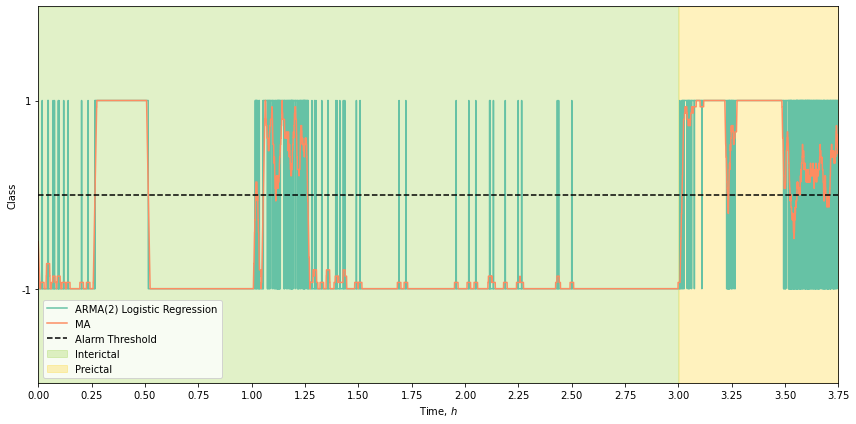

In [18]:
# online predictor response
plt.figure(figsize=(12,6))

sns.set_palette(sns.color_palette('Set2'))

m = 30
ma_predict_sig = np.convolve(prediction_sig, np.ones(m)/m, mode='same')

ax = sns.lineplot(x=pt, y=prediction_sig, label='ARMA(2) Logistic Regression')
sns.lineplot(x=pt, y=ma_predict_sig, label='MA')
ax.axhline(y=0, ls='--', color='k', label='Alarm Threshold')
ax.fill_between(pt, 0, 1, where=pt < t_preictal, color='#9cd34a', alpha=0.3, transform=ax.get_xaxis_transform(), label='Interictal')
ax.fill_between(pt, 0, 1, where=pt > t_preictal, color='#ffd429', alpha=0.3, transform=ax.get_xaxis_transform(), label='Preictal')

plt.xticks(np.arange(0,3.76,0.25))
tickpos = [-1,1] # show only classes: -1 and 1
plt.yticks(tickpos,tickpos)

plt.xlim([0,3.75])
plt.ylim([-2,2])
plt.xlabel('Time, $h$')
plt.ylabel('Class')
plt.legend(loc=3)
plt.tight_layout()
plt.savefig('./figures/chb01_AR_Logistic_Regression_RT.pdf')
plt.show()